# Navier Stokes Equatoin

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()
print(f"This machine has {num_cores} cores.")

# Set Numba to use all of them
numba.set_num_threads(num_cores)
print(f"Numba is set to use {numba.get_num_threads()} threads.")

# --- Core imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div
)
from pycutfem.ufl.measures import dx
from pycutfem.ufl.forms import BoundaryCondition, assemble_form
from pycutfem.fem.mixedelement import MixedElement







This machine has 8 cores.
Numba is set to use 8 threads.


/home/jamal/anaconda3/envs/pycutfem/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
# ============================================================================
#    NEW: Verification Data and Plotting Function
# ============================================================================

# Digitized data from Ghia, Ghia, and Shin (1982), Table 1 for Re=100
ghia_data_re100 = {
    'y_locations': np.array([0.0, 0.0547, 0.0625, 0.0703, 0.1016, 0.1719, 0.2813, 0.4531, 0.5, 0.6172, 0.7344, 0.8516, 0.9531,0.9609,0.9688,0.9766,1.0]),
    'u_velocity_on_vertical_centerline': np.array([0.0, -0.03717, -0.04192, -0.04775, -0.06434, -0.10150, -0.15662, -0.21090, -0.20581, -0.13641, 0.00332, 0.23151,0.68717,0.73722,0.78871,0.84123,1.0]),
    'x_locations': np.array([0.0, 0.0625, 0.0703, 0.0781, 0.0938, 0.1563, 0.2266, 0.2344, 0.5, 0.8047, 0.8594, 0.9063, 0.9453, 0.9531, 0.9609, 0.9688, 1.0]),
    'v_velocity_on_horizontal_centerline': np.array([0.0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507,0.17527,0.05454,-.24533,-.22445,-.16914,-.10313,-.08864,-.07391,-.05906,0.0])
}



In [3]:
# 1. ============================================================================
#    SETUP (Meshes, DofHandler, BCs)
# ===============================================================================
L, H = 1.0, 1.0
# MODIFIED: Increased resolution for better accuracy
NX, NY = 30, 30
nodes_q2, elems_q2, _, corners_q2 = structured_quad(L, H, nx=NX, ny=NY, poly_order=2)
mesh_q2 = Mesh(nodes=nodes_q2, element_connectivity=elems_q2, elements_corner_nodes=corners_q2, element_type="quad", poly_order=2)
mixed_element = MixedElement(mesh_q2, field_specs={'ux': 2, 'uy': 2, 'p': 1})

dof_handler = DofHandler(mixed_element, method='cg')

# Tag boundaries for applying BCs
bc_tags = {
    'bottom_wall': lambda x,y: np.isclose(y,0),
    'left_wall':   lambda x,y: np.isclose(x,0),
    'right_wall':  lambda x,y: np.isclose(x,L),
    'top_lid':     lambda x,y: np.isclose(y,H)
}
mesh_q2.tag_boundary_edges(bc_tags)

# Tag a single node for pressure pinning
dof_handler.tag_dof_by_locator(
    tag='pressure_pin_point', field='p',
    locator=lambda x, y: np.isclose(x, 0.0) and np.isclose(y, 0.0),
    find_first=True
)

# MODIFIED: Boundary conditions for the classic lid-driven cavity problem
bcs = [
    # No-slip on bottom, left, and right walls
    BoundaryCondition('ux', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    # Moving lid on the top wall (ux=1, uy=0)
    BoundaryCondition('ux', 'dirichlet', 'top_lid',     lambda x,y: 1.0),
    BoundaryCondition('uy', 'dirichlet', 'top_lid',     lambda x,y: 0.0),
    # Pin pressure at one point to ensure a unique solution
    BoundaryCondition('p', 'dirichlet', 'pressure_pin_point',lambda x,y: 0.0)
]

bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x,y: 0.0) for bc in bcs]
print(f"DofHandler info: {dof_handler.info()}")

=== DofHandler (CG) ===
        ux: 3721 DOFs @ offset 0
        uy: 3721 DOFs @ offset 9
         p: 961 DOFs @ offset 18
  total : 8403
DofHandler info: None


In [4]:
# 2. ============================================================================
#    UFL FORMULATION
# ===============================================================================
rho = Constant(1.0)
dt = Constant(0.1)
theta = Constant(1.0) # Use Backward Euler for stability (theta=1.0)
# MODIFIED: Set viscosity for Re=100
mu = Constant(0.01) # Re = (1.0 * 1.0 * 1.0) / 0.01 = 100

velocity_space = FunctionSpace("velocity", ['ux', 'uy'])
pressure_space = FunctionSpace("pressure", ['p'])

du = VectorTrialFunction(velocity_space, dof_handler=dof_handler)
dp = TrialFunction(pressure_space, dof_handler=dof_handler)
v = VectorTestFunction(velocity_space, dof_handler=dof_handler)
q = TestFunction(pressure_space, dof_handler=dof_handler)

u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
# p_n is not needed for the steady state formulation if theta=1.0, but we keep it for consistency
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)


In [5]:
u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)

# --- NEW: JIT Compile Forms ONCE Before the Loop ---
print("\nJIT compiling Jacobian and Residual forms...")
jacobian_form = (
    rho * dot(du, v) / dt + 
    theta * rho * dot(dot(grad(u_k), du), v) +
    theta * rho * dot(dot(grad(du), u_k), v) + 
    theta * mu * inner(grad(du), grad(v)) 
    -dp * div(v) + q * div(du)
) * dx()

residual_form = (
    rho * dot(u_k - u_n, v) / dt 
    + theta *rho * dot( dot(grad(u_k), u_k), v) +
    (1.0 - theta) * rho * dot( dot(grad(u_n), u_n), v) +
    theta * mu * inner(grad(u_k), grad(v)) +
    (1.0 - theta) * mu * inner(grad(u_n), grad(v)) 
    -p_k * div(v) + q * div(u_k)
) * dx()


JIT compiling Jacobian and Residual forms...


In [6]:
len(dof_handler.get_dirichlet_data(bcs))

481

In [7]:
from pycutfem.solvers.nonlinear_solver import (NewtonSolver, 
                                               NewtonParameters, 
                                               TimeStepperParameters, 
                                               AdamNewtonSolver, 
                                               GiantInexactNewtonSolver,
                                               PetscSnesNewtonSolver)
from pycutfem.solvers.aainhb_solver import AAINHBSolver

# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=0.1, 
                                    stop_on_steady=True, 
                                    steady_tol=1e-6, theta= theta.value)

# solver = NewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
# )
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )
# solver = GiantInexactNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6, line_search=False),
# )
solver = PetscSnesNewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
    petsc_options={
        "snes_monitor": None,
        "snes_converged_reason": None,
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "snes_type": "newtonls",
        "snes_linesearch_type": "bt",
        "snes_linesearch_damping": 1.0,
    },
)


# solver.set_schur_fieldsplit(
#     {"u": ["ux", "uy"], "p": ["p"]},
#     schur_fact="full",
#     schur_pre="selfp",
#     sub_pc={"u": "hypre", "p": "jacobi"},   # defaults; tune as needed
# )

# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]

solver.solve_time_interval(functions=functions,prev_functions= prev_functions,
                           time_params=time_params,)

No Restriction operators found. All DOFs are considered active.
NewtonSolver: Reduced system with 7922/8403 DOFs.
  Dirichlet DOFs detected: 481; Free DOFs: 7922
  0 SNES Function norm 3.258967740748e-01
  1 SNES Function norm 4.994095218571e-02
  2 SNES Function norm 1.648700634192e-03
  3 SNES Function norm 6.175060449986e-06
  4 SNES Function norm 1.046365425067e-10
  Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 4
    Time step 1: ΔU = 2.17e+00
  0 SNES Function norm 3.571765279904e-01
  1 SNES Function norm 7.492905520974e-02
  2 SNES Function norm 2.894937849460e-03
  3 SNES Function norm 2.650603859839e-05
  4 SNES Function norm 2.515469067232e-09
  Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 4
    Time step 2: ΔU = 1.88e-01
  0 SNES Function norm 3.679781362743e-01
  1 SNES Function norm 8.156531692296e-02
  2 SNES Function norm 3.515620650356e-03
  3 SNES Function norm 3.962987784544e-05
  4 SNES Function norm 6.035709699019e-09
  Nonlinea

Error: error code 101
[0] SNESSolve() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1748704148/work/src/snes/interface/snes.c:4846
[0] SNESSolve_NEWTONLS() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1748704148/work/src/snes/impls/ls/ls.c:218
[0] SNESComputeJacobian() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1748704148/work/src/snes/interface/snes.c:2953

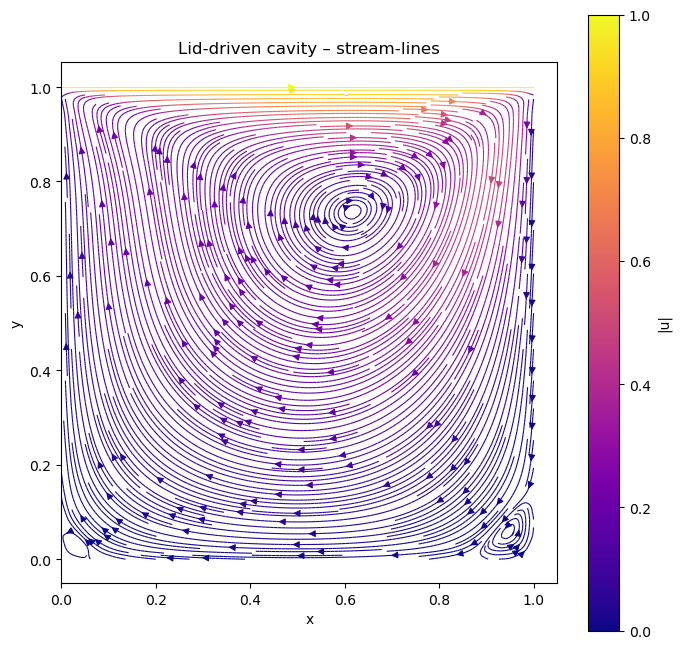

In [8]:
u_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Lid-driven cavity – stream-lines",background = False)

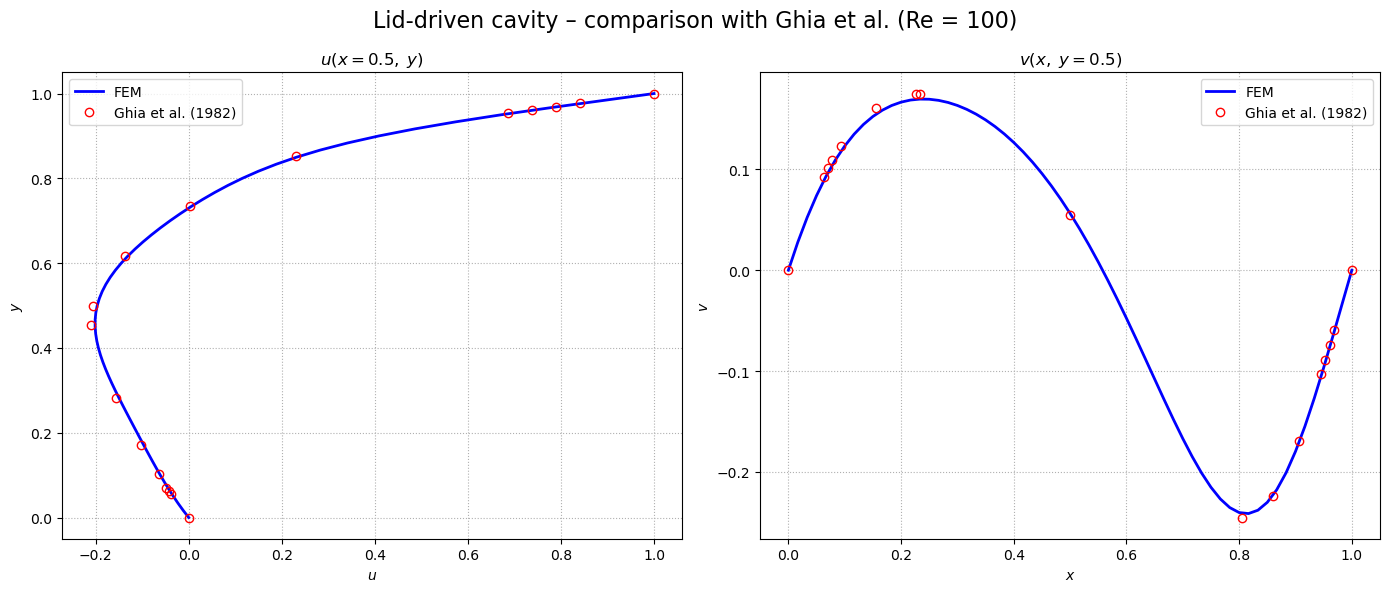

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pycutfem.plotting import _extract_profile_1d


# ---------------------------------------------------------------------------


def create_verification_plot(dh, u_vec, reference_data, *,
                             x_center=0.5, y_center=0.5):
    """
    Compare the FEM velocity field *u_vec* (VectorFunction) against the
    Ghia et al. (1982) reference data for Re=100.

    Parameters
    ----------
    dh : DofHandler
        The handler that owns *u_vec*.
    u_vec : VectorFunction
        Solution with components ['ux', 'uy'].
    reference_data : dict
        Dict with keys 'x_locations', 'y_locations',
        'u_velocity_on_vertical_centerline',
        'v_velocity_on_horizontal_centerline'.
    x_center, y_center : float, optional
        Position of the vertical / horizontal centre-lines.
    """
    # ------------------------------------------------------------------
    # 1. Extract smooth centre-line profiles from the solution
    # ------------------------------------------------------------------
    ux_vals = u_vec.components[0].nodal_values   # or u_vec[0].nodal_values
    uy_vals = u_vec.components[1].nodal_values

    y_sol, u_sol = _extract_profile_1d('ux', dh, ux_vals,
                                       line_axis='x', line_pos=x_center)
    x_sol, v_sol = _extract_profile_1d('uy', dh, uy_vals,
                                       line_axis='y', line_pos=y_center)

    # ------------------------------------------------------------------
    # 2. Plot comparison
    # ------------------------------------------------------------------
    fig, (ax_u, ax_v) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    fig.suptitle("Lid-driven cavity – comparison with Ghia et al. (Re = 100)",
                 fontsize=16)

    # u-velocity along vertical centre-line
    ax_u.plot(u_sol, y_sol, 'b-', lw=2, label='FEM')
    ax_u.plot(reference_data['u_velocity_on_vertical_centerline'],
              reference_data['y_locations'],
              'ro',  mfc='none', label='Ghia et al. (1982)')
    ax_u.set_xlabel(r'$u$');  ax_u.set_ylabel(r'$y$')
    ax_u.set_title(r'$u(x=0.5,\;y)$')
    ax_u.grid(ls=':')
    ax_u.legend()

    # v-velocity along horizontal centre-line
    ax_v.plot(x_sol, v_sol, 'b-', lw=2, label='FEM')
    ax_v.plot(reference_data['x_locations'],
              reference_data['v_velocity_on_horizontal_centerline'],
              'ro',  mfc='none', label='Ghia et al. (1982)')
    ax_v.set_xlabel(r'$x$');  ax_v.set_ylabel(r'$v$')
    ax_v.set_title(r'$v(x,\;y=0.5)$')
    ax_v.grid(ls=':')
    ax_v.legend()

    plt.tight_layout()
    plt.show()

create_verification_plot(dof_handler, u_n, ghia_data_re100)